In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import warnings
import geobr
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
from shapely.geometry import mapping
import math
warnings.filterwarnings("ignore")



In [17]:
def load_state():
    state = geobr.read_state(code_state="SP")
    state = state.to_crs("EPSG:4326")
    return state, state.unary_union

def load_municipality():
    muni = geobr.read_municipality(code_muni="SP")
    muni = muni.to_crs("EPSG:4326")
    return muni, muni.unary_union

def open_dataset(data_dir, years, percentile, duration):
    file = f"heatwaves_{years[0]}_{years[-1]}_p{percentile}_threshold_events_{duration}_days_area_sao_paulo.nc"
    ds = xr.open_dataset(os.path.join(data_dir, file))
    ds = ds.rio.write_crs("EPSG:4326", inplace=False)
    ds = ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)
    return ds

def compute_mean_events(ds, region_gdf):
    years = ds["year"].values
    mean_event_days = {}
    for year in years:
        data = ds["event_dummy"].sel(year=year).sum(dim="valid_time")
        da_crop = data.rio.clip([mapping(region_gdf.unary_union)], region_gdf.crs, drop=True)
        mean_event_days[int(year)] = float(da_crop.mean().values)
    return pd.DataFrame.from_dict(mean_event_days, orient="index", columns=["mean_event_days"])

def plot_yearly_maps(ds, region_gdf, duration):
    years = ds["year"].values
    ncols = 4
    nrows = int(np.ceil(len(years) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, nrows * 4), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    xmin, ymin, xmax, ymax = region_gdf.total_bounds

    xmin = math.floor(xmin * 2) / 2
    xmax = math.ceil(xmax * 2) / 2
    ymin = math.floor(ymin * 2) / 2
    ymax = math.ceil(ymax * 2) / 2
    
    for i, year in enumerate(years):
        ax = axes[i]
        data = ds["event_dummy"].sel(year=year).sum(dim="valid_time")
        da_crop = data.rio.clip([mapping(region_gdf.unary_union)], region_gdf.crs, drop=True)

        levels = np.arange(0, 40, 2)
        im = da_crop.plot(ax=ax, cmap="Reds", levels=levels, add_colorbar=False, transform=ccrs.PlateCarree())
        ax.set_title(str(year))
        region_gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
        ax.set_extent([xmin, xmax, ymin, ymax])
        gl = ax.gridlines(draw_labels=True, linewidth=0.2, color="gray", alpha=0.5)
        gl.top_labels = False
        gl.right_labels = False
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Días con evento")
    fig.suptitle(f"Ocurrencias anuales de olas de calor (2010–2025) - {duration} días", fontsize=14, y=0.95)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.show()

def plot_bar_absolute(df_all):
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(df_all))
    width = 0.25
    ax.bar(x - width, df_all["3_days"], width, label="3 días", color='skyblue')
    ax.bar(x, df_all["5_days"], width, label="5 días", color='lightgreen')
    ax.bar(x + width, df_all["7_days"], width, label="7 días", color='salmon')
    ax.set_xticks(x)
    ax.set_xticklabels(df_all.index, rotation=45)
    ax.set_ylabel("Promedio de días con evento")
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

def plot_bar_percentage(df_all):
    df_pct = df_all.copy()
    df_pct["3_days"] = (df_pct["3_days"] / 365) * 100
    df_pct["5_days"] = (df_pct["5_days"] / 365) * 100
    df_pct["7_days"] = (df_pct["7_days"] / 365) * 100
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(df_pct))
    width = 0.25
    ax.bar(x - width, df_pct["3_days"], width, label="3 días", color='skyblue')
    ax.bar(x, df_pct["5_days"], width, label="5 días", color='lightgreen')
    ax.bar(x + width, df_pct["7_days"], width, label="7 días", color='salmon')
    ax.set_xticks(x)
    ax.set_xticklabels(df_pct.index, rotation=45)
    ax.set_ylabel("Porcentaje de días con evento (%)")
    ax.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 4)
    plt.tight_layout()
    plt.show()


def plot_spatial_field(da, region_gdf, title="", cmap="YlOrRd", vmin=None, vmax=None, levels=None):
    da = da.rio.write_crs("EPSG:4326", inplace=True)
    da_crop = da.rio.clip([mapping(region_gdf.unary_union)], region_gdf.crs, drop=True)

    xmin, ymin, xmax, ymax = region_gdf.total_bounds
    xmin = math.floor(xmin * 2) / 2
    xmax = math.ceil(xmax * 2) / 2
    ymin = math.floor(ymin * 2) / 2
    ymax = math.ceil(ymax * 2) / 2

    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})

    im = da_crop.plot(
        ax=ax,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        levels=levels,
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

    ax.set_title("")

    region_gdf.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.set_extent([xmin, xmax, ymin, ymax])

    gl = ax.gridlines(draw_labels=True, linewidth=0.2, color="gray", alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    ax.tick_params(labelsize=7)

    if title:
        ax.set_title(title, fontsize=10, loc="left")        

    cbar = plt.colorbar(im, orientation="vertical", pad=0.05, aspect=50, shrink=0.7)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label("Temperatura (°C)", fontsize=9)

    plt.tight_layout()
    plt.show()

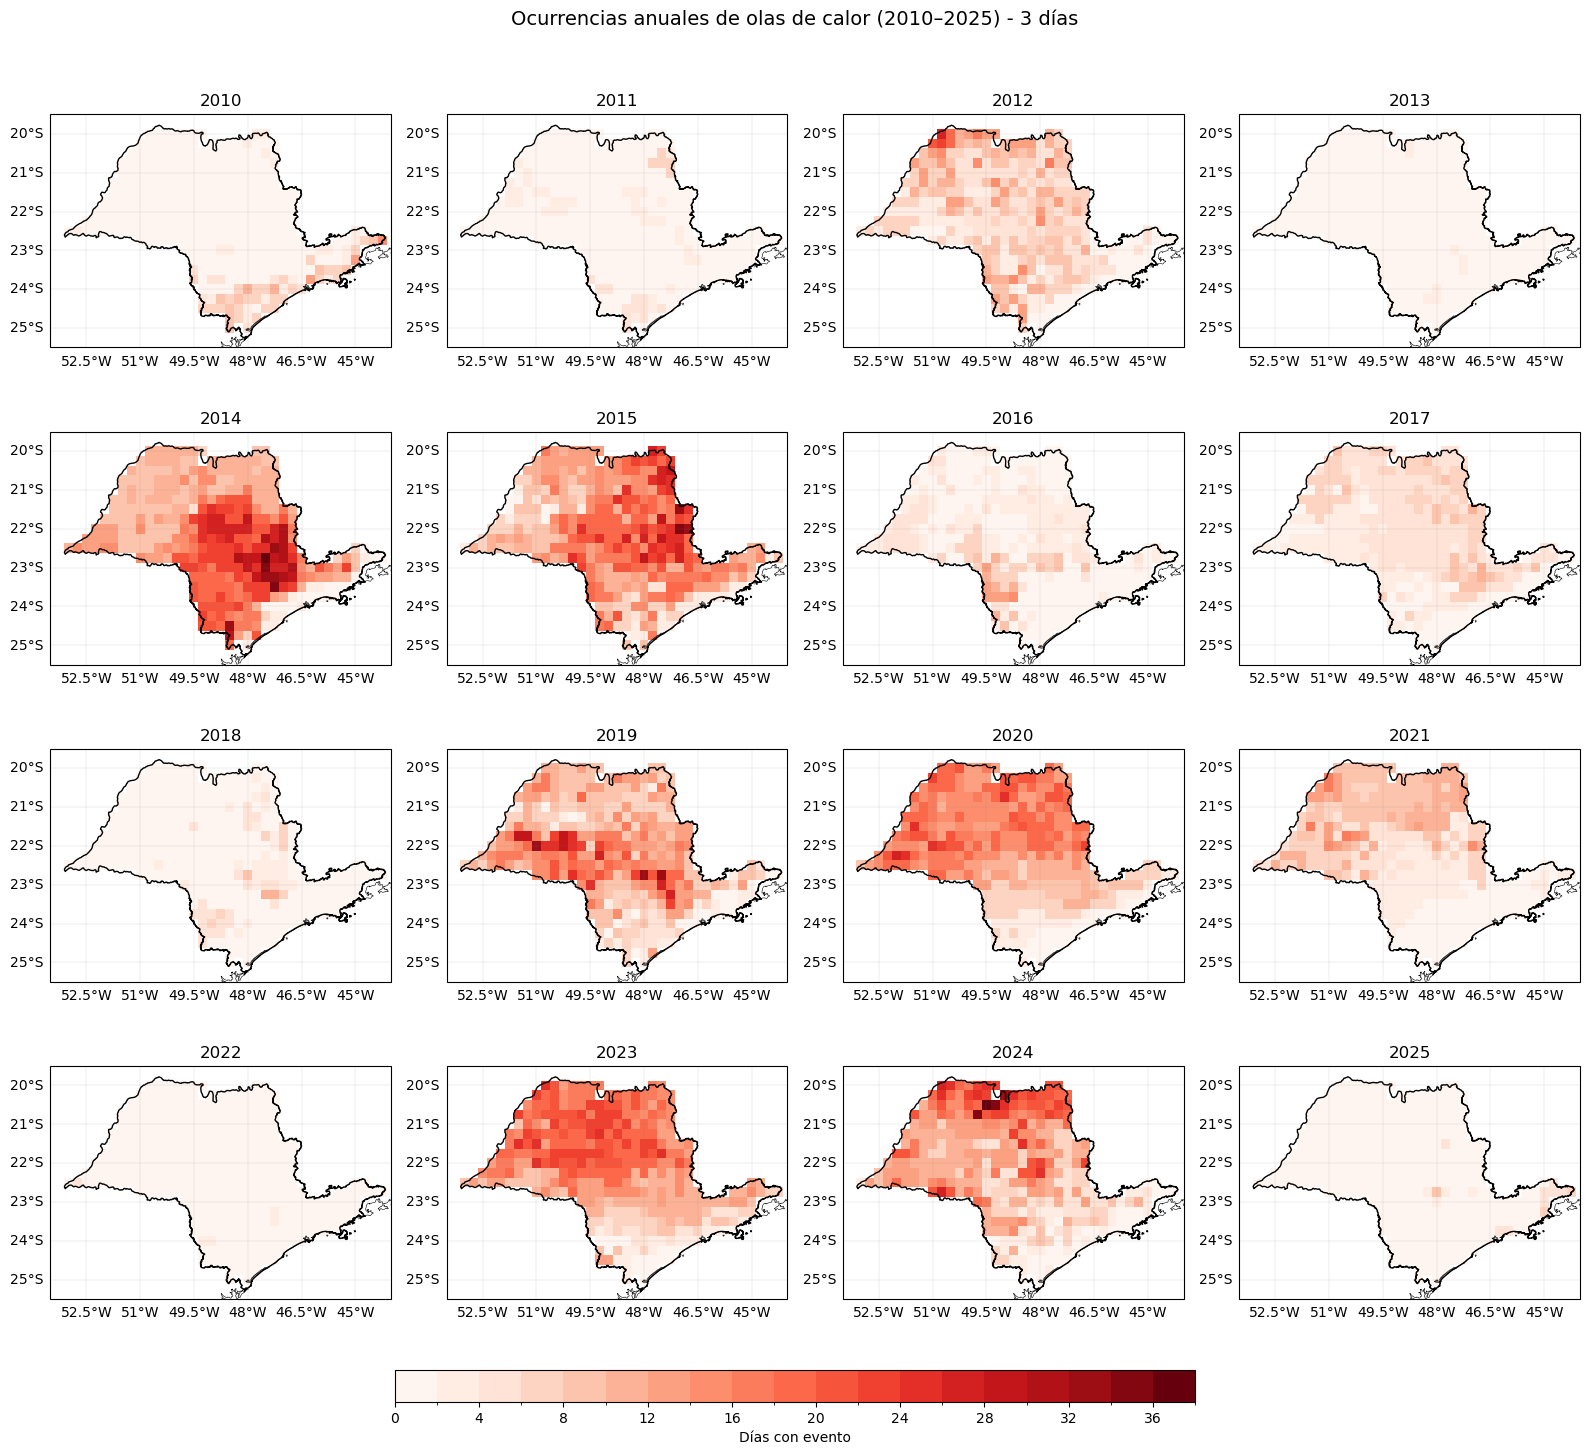

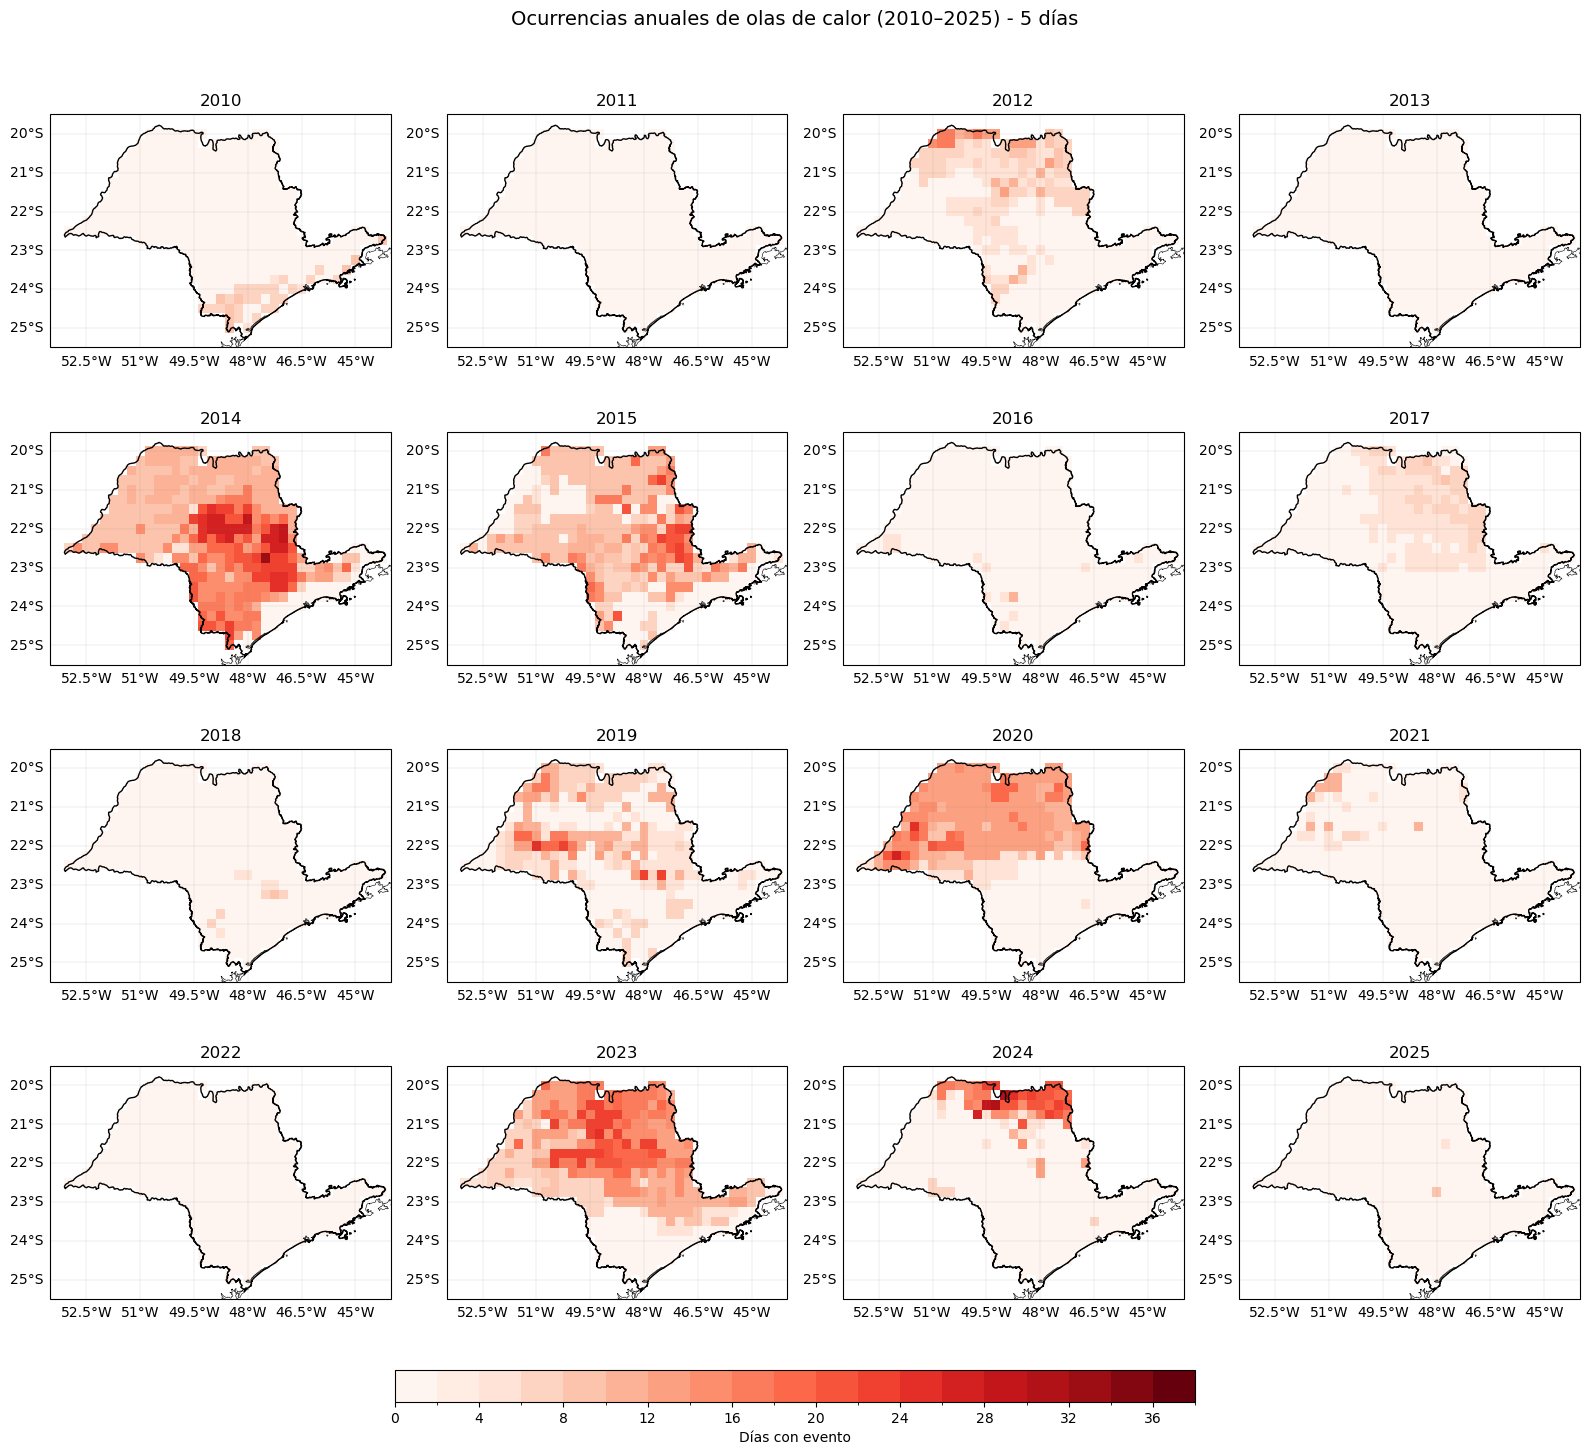

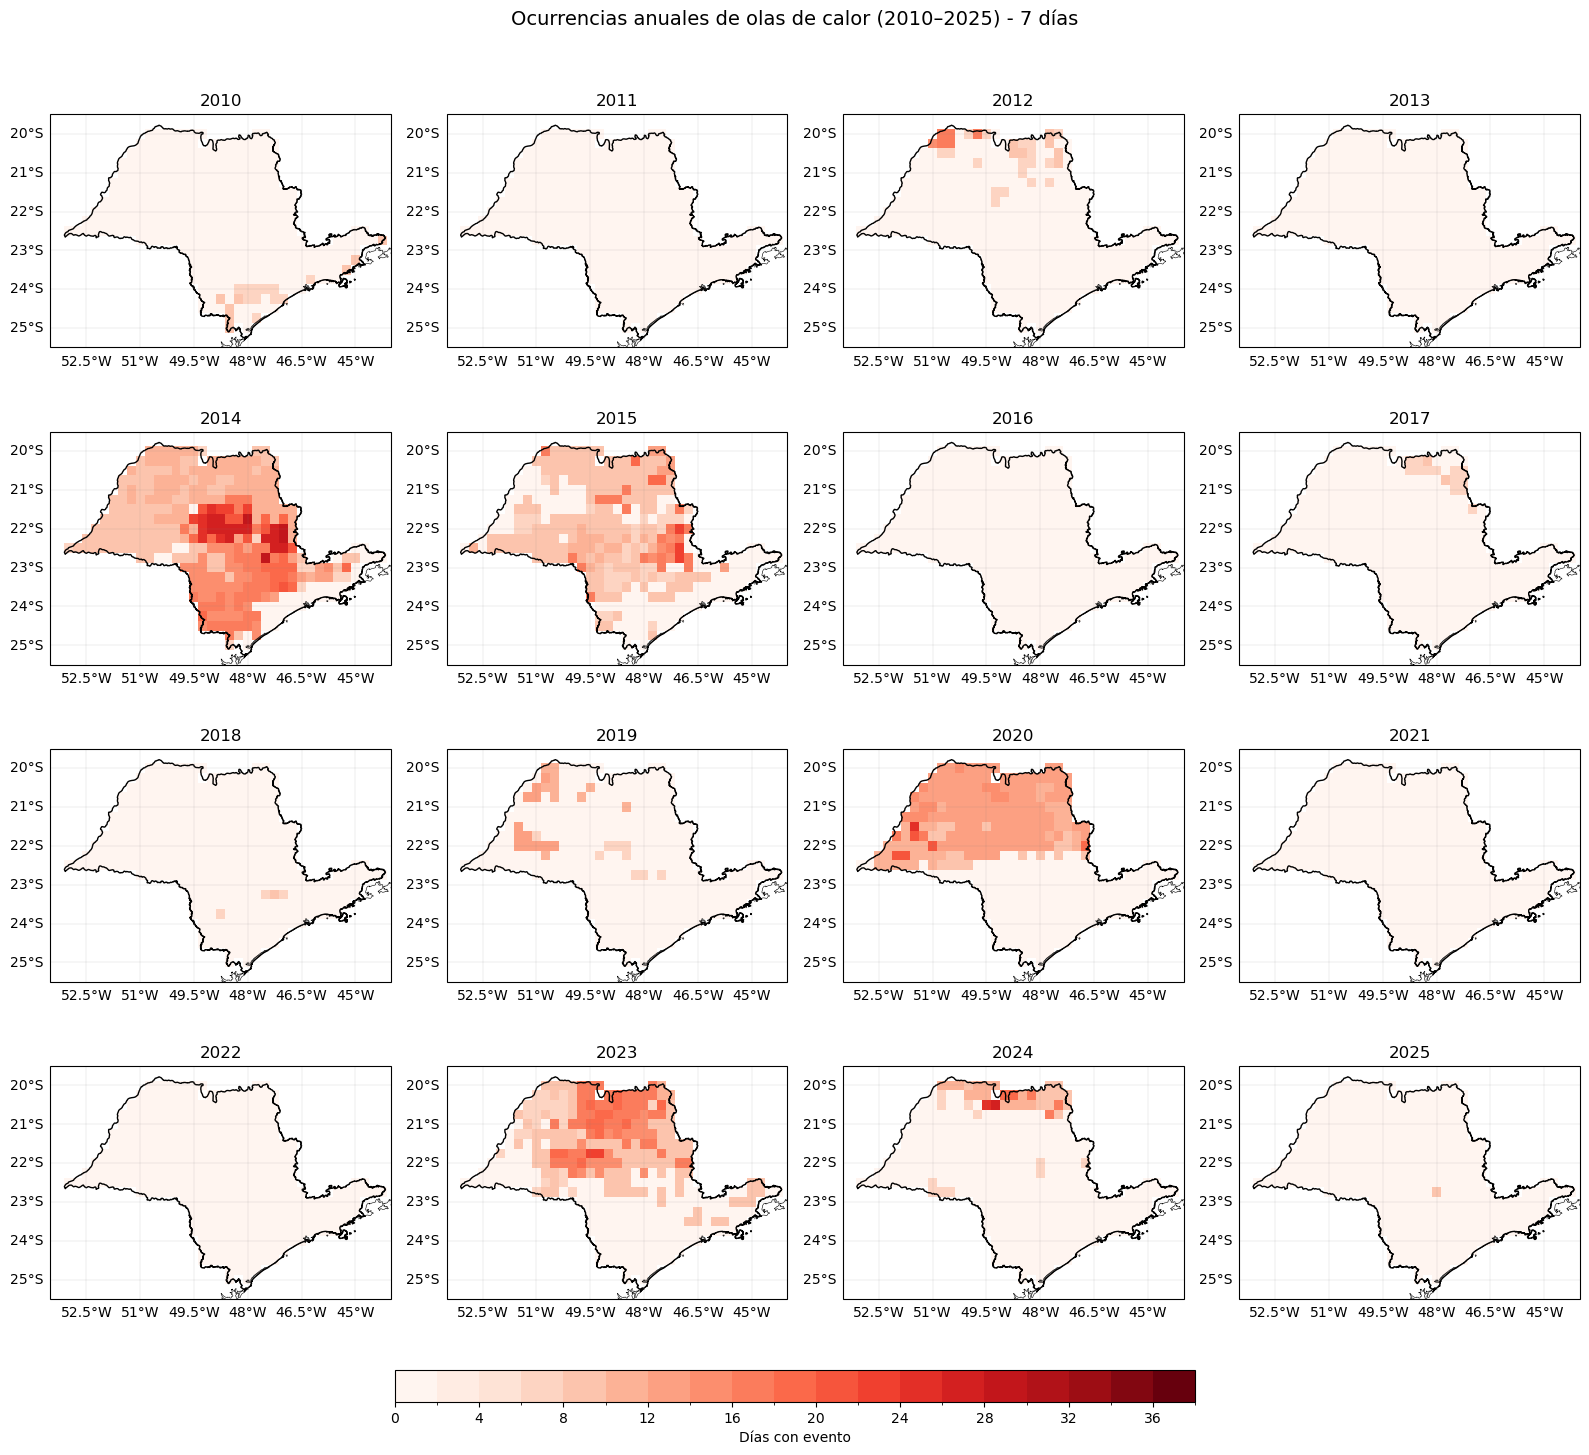

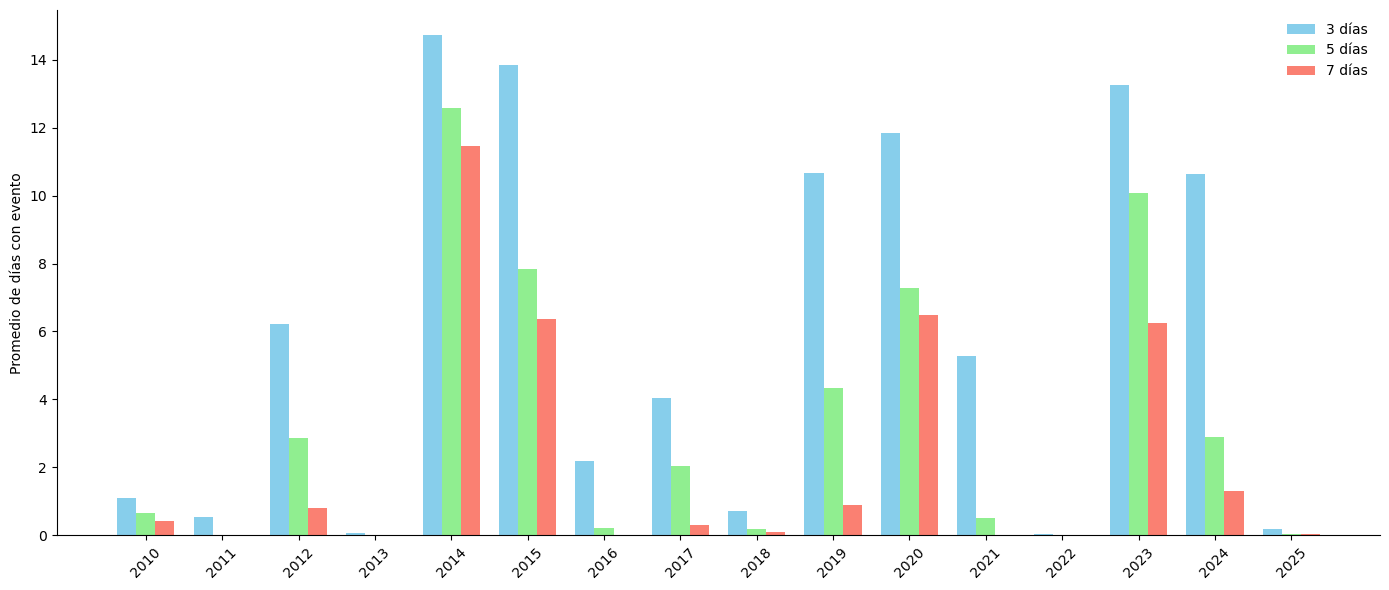

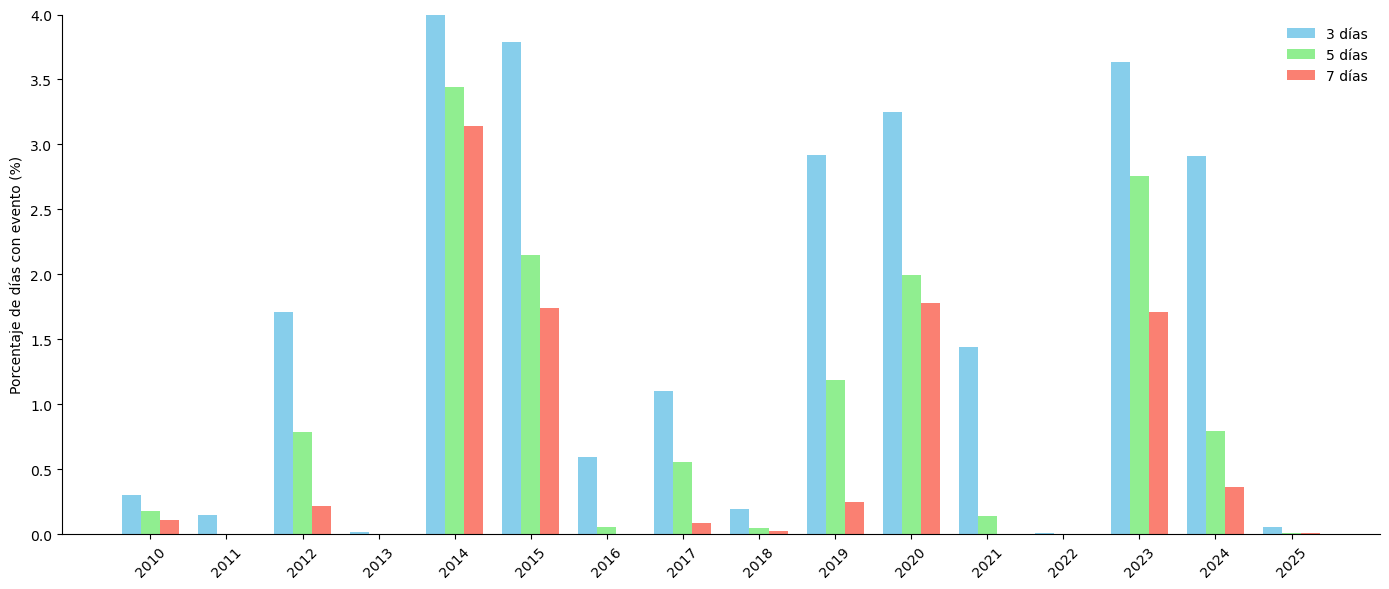

In [14]:

list_years = np.arange(2010, 2026)
durations = [3, 5, 7]
percentile = 98

data_processed_dir = "../data/processed/"
data_raw_dir = "../data/raw/"

state, polygon = load_state()
df_all = pd.DataFrame(index=list_years)
for d in durations:
    ds = open_dataset(data_processed_dir, list_years, percentile, d)
    plot_yearly_maps(ds, state, d)
    df_mean = compute_mean_events(ds, state)
    df_mean.columns = [f"{d}_days"]
    df_all = df_all.join(df_mean, how="left")
plot_bar_absolute(df_all)
plot_bar_percentage(df_all)


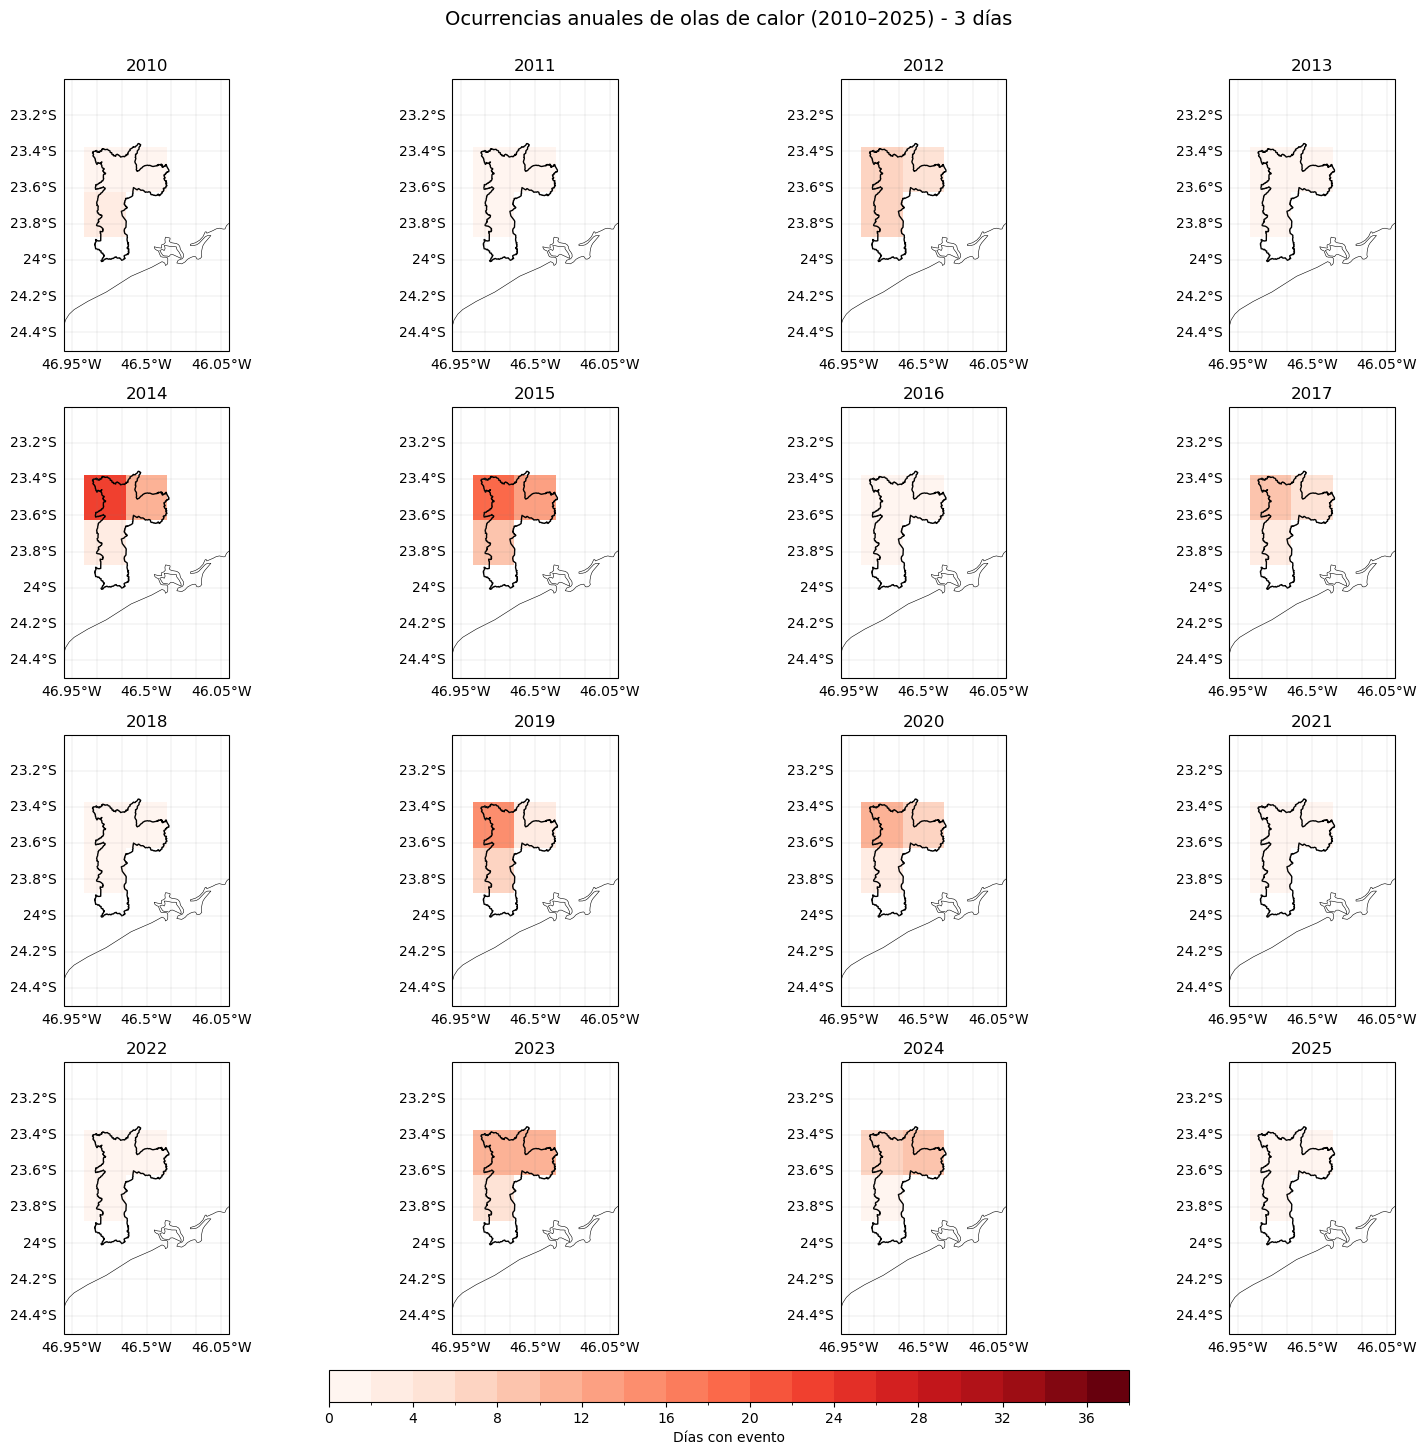

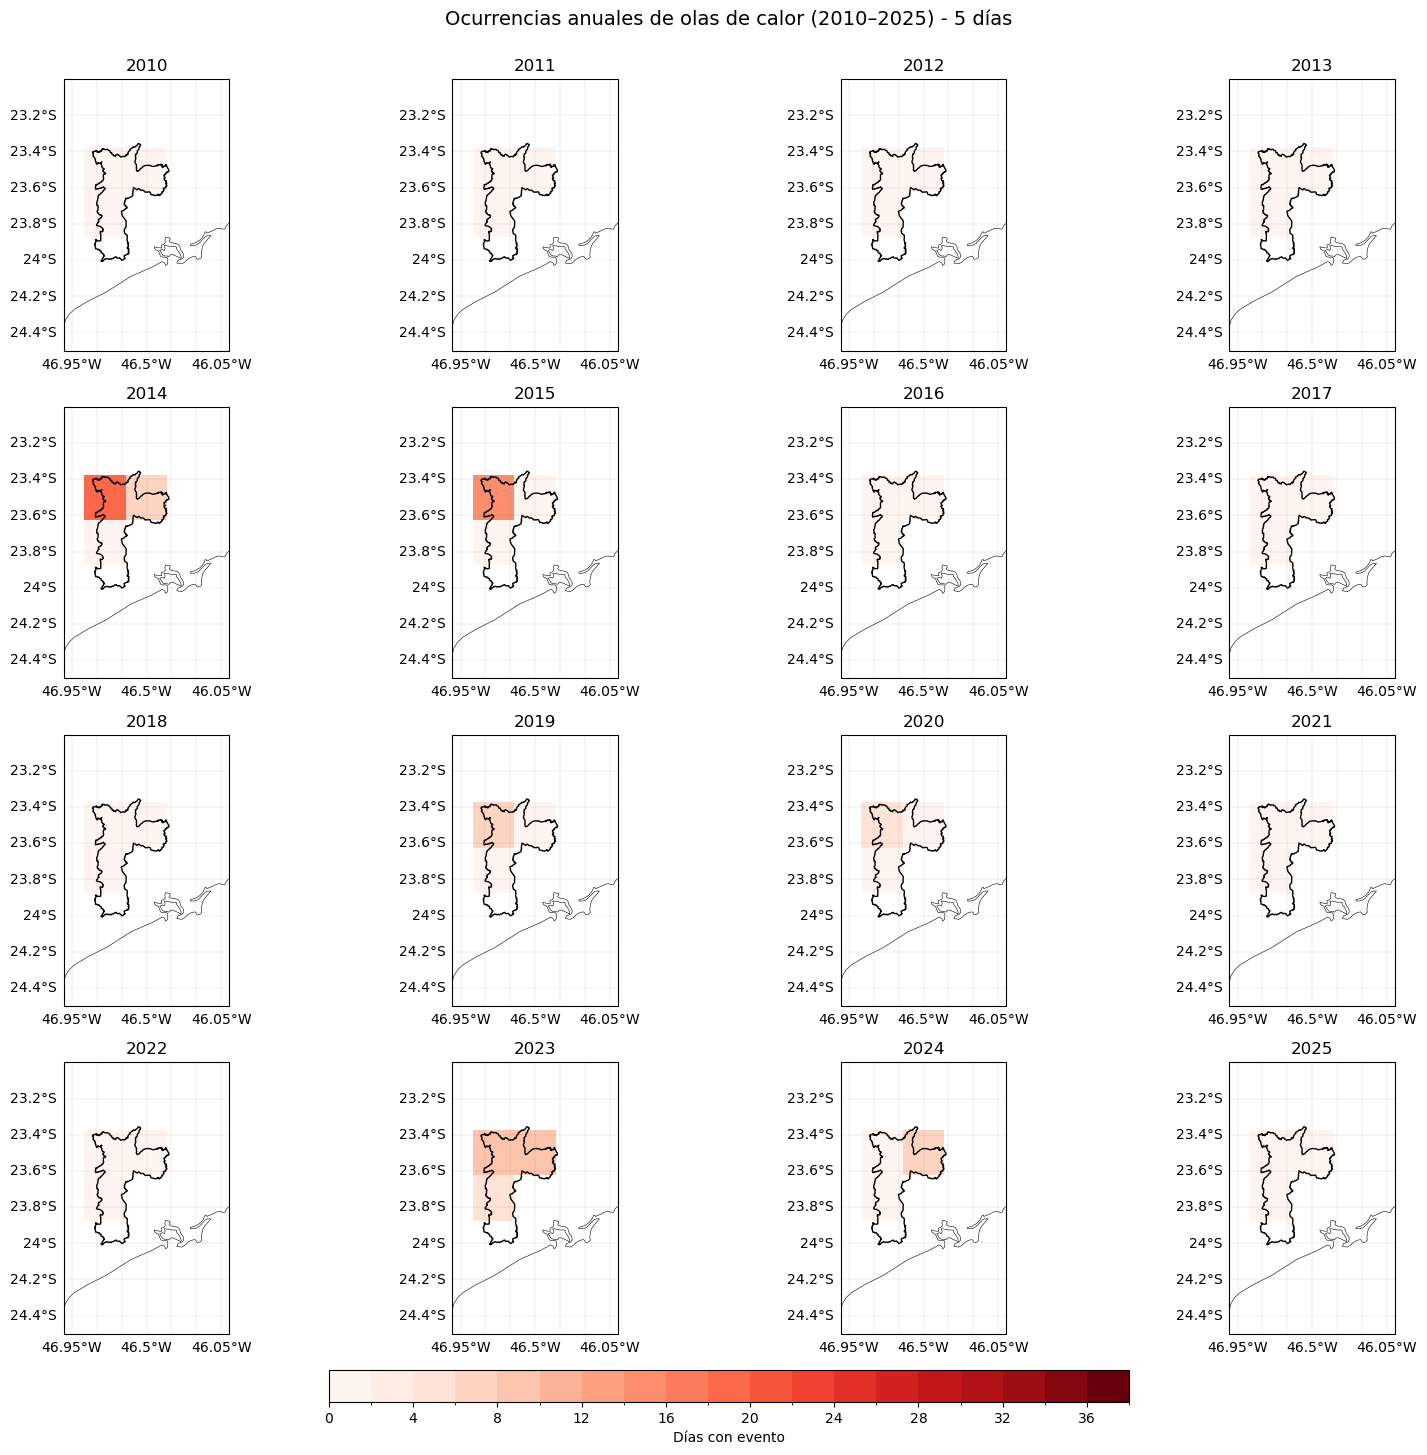

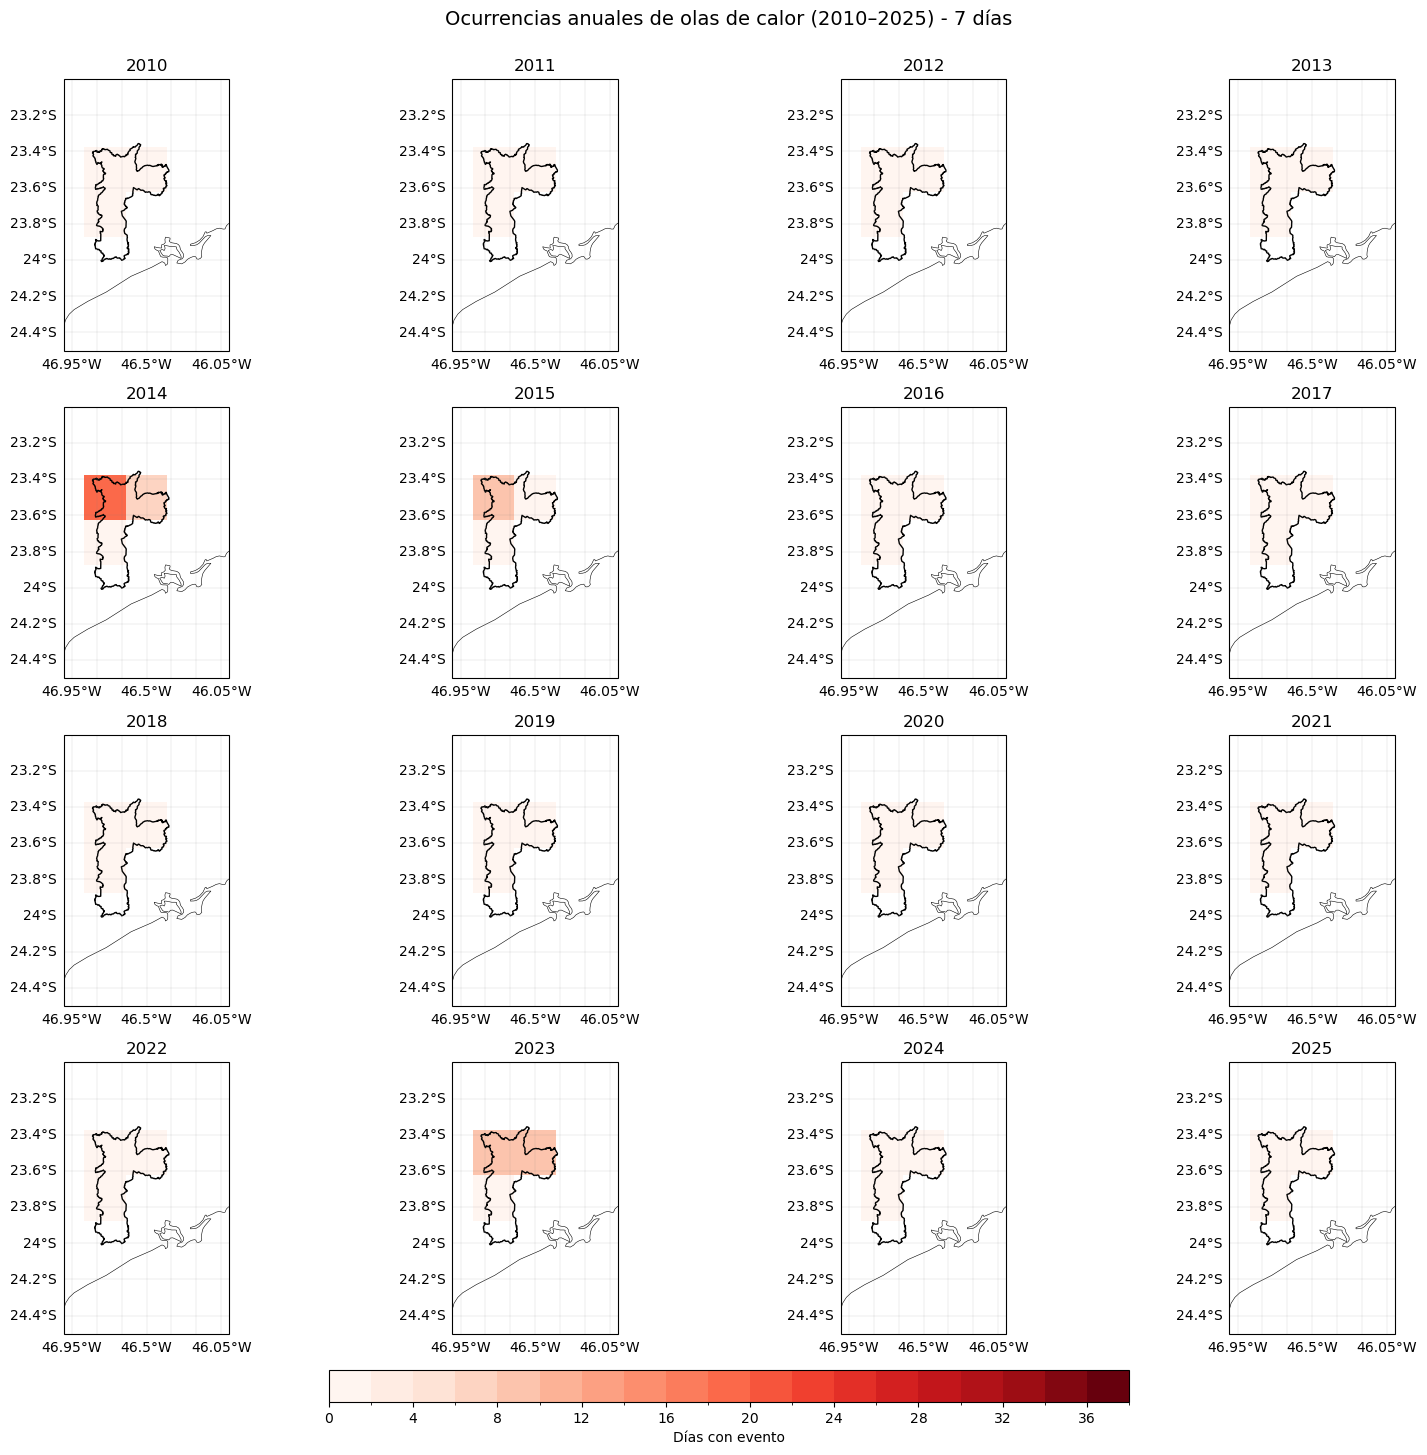

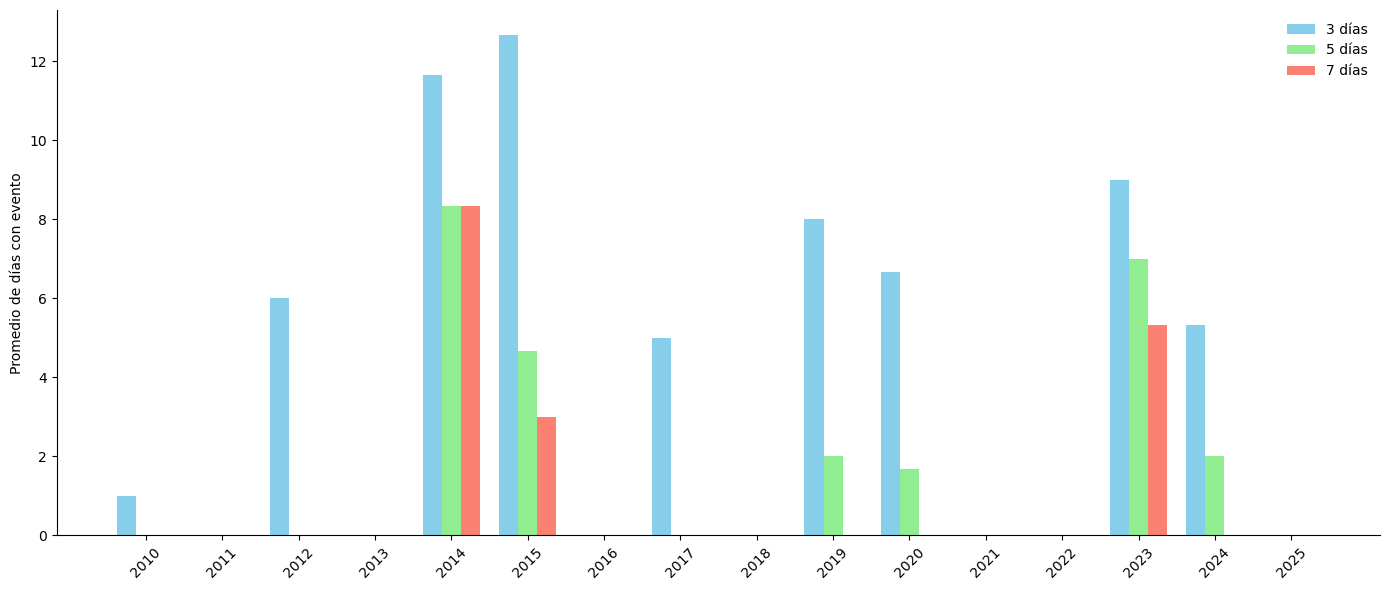

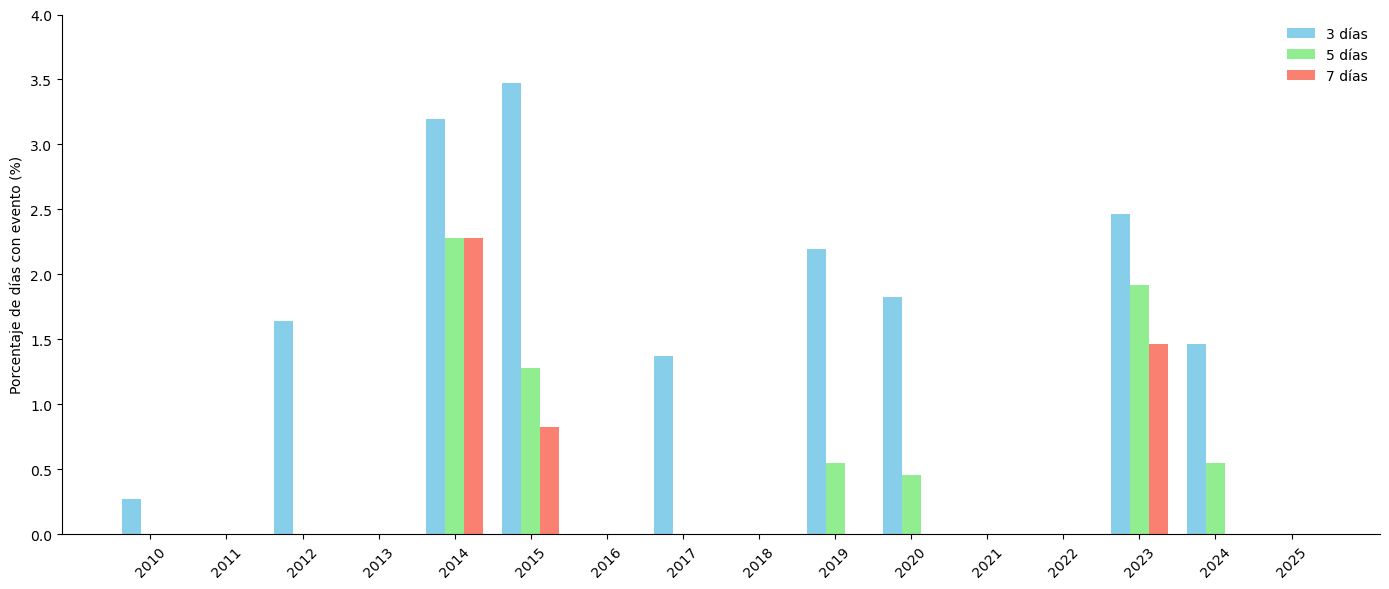

In [15]:

muni, _ = load_municipality()
muni = muni.to_crs("EPSG:4326")
muni = muni[muni["name_muni"] == "São Paulo"]

list_years = np.arange(2010, 2026)
durations = [3, 5, 7]
percentile = 98
data_processed_dir = "../data/processed/"
df_all = pd.DataFrame(index=list_years)

for d in durations:
    ds = open_dataset(data_processed_dir, list_years, percentile, d)
    plot_yearly_maps(ds, muni, d)
    df_mean = compute_mean_events(ds, muni)
    df_mean.columns = [f"{d}_days"]
    df_all = df_all.join(df_mean, how="left")
plot_bar_absolute(df_all)
plot_bar_percentage(df_all)


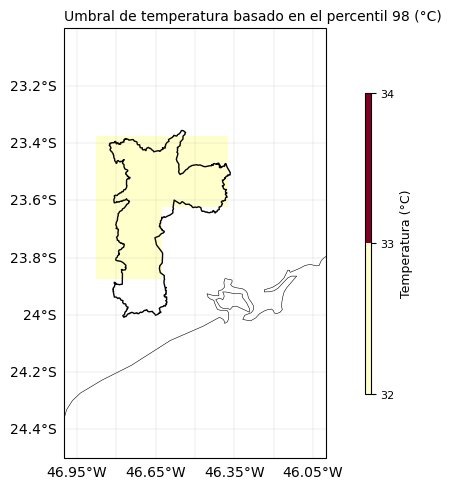

In [23]:


region = [6, -74, -34, -33]

climatology_years = [1995, 2024]
file_percentiles = f'tmax2m_mean_and_percentiles_{climatology_years[0]}_{climatology_years[1]}_area_{region[0]}N_{region[1]}W_{region[2]}S_{region[3]}E.nc'
files_raw = sorted([file for file in os.listdir(data_raw_dir) if file.endswith(".nc")])

ds_percentiles = xr.open_dataset(data_processed_dir + file_percentiles)

# --- Recorte espacial São Paulo ---
lat_min, lat_max = -25.4, -19.7
lon_min, lon_max = -53.25, -44

if ds_percentiles.latitude[0] > ds_percentiles.latitude[-1]:
    ds_percentiles = ds_percentiles.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
else:
    ds_percentiles = ds_percentiles.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
# ----------------------------------

percentile = 98 
p_percentile = ds_percentiles[f't2m_p{percentile}']
p_percentile_mean = p_percentile.round(0)


plot_spatial_field(
    p_percentile_mean,
    region_gdf=muni,
    title="Umbral de temperatura basado en el percentil 98 (°C)",
    cmap="YlOrRd",
    levels=np.arange(32, 35, 1)
)

### Extract csv for bootstrap


In [41]:
duration = 3
ds = open_dataset(data_processed_dir, list_years, percentile, duration)

<xarray.Dataset> Size: 1GB
Dimensions:          (year: 16, valid_time: 5691, latitude: 23, longitude: 38)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 46kB 2010-01-01 ... 2025-07-31
  * latitude         (latitude) float64 184B -19.75 -20.0 ... -25.0 -25.25
  * longitude        (longitude) float64 304B -53.25 -53.0 ... -44.25 -44.0
  * year             (year) int64 128B 2010 2011 2012 2013 ... 2023 2024 2025
    spatial_ref      int64 8B 0
Data variables:
    tmax2m           (year, valid_time, latitude, longitude) float32 318MB ...
    event_dummy      (year, valid_time, latitude, longitude) float32 318MB ...
    magnitude_event  (year, valid_time, latitude, longitude) float32 318MB ...
    anomaly_event    (year, valid_time, latitude, longitude) float32 318MB ...

In [83]:
vars_to_keep = ["tmax2m", "event_dummy", "magnitude_event", "anomaly_event"]

da = ds.rio.clip([mapping(muni.unary_union)], muni.crs, drop=True)
da_point = da.sel(latitude=-23.5, longitude=-46.75, method="nearest")

da_point = da_point.max(dim="year", skipna=True)

df = (
    da_point[vars_to_keep]
    .to_dataframe()
    .reset_index()
    .rename(columns={"valid_time": "date"})
)

df_tmax = df[["date", "tmax2m"]]
df_tmax.to_csv(f"../data/processed/tmax2m_sp_point.csv", index=False)

<Axes: xlabel='date'>

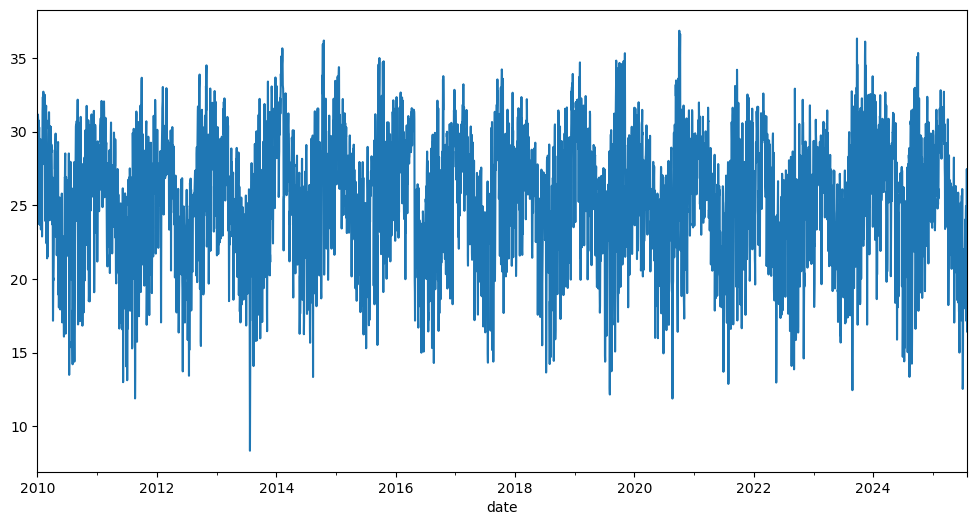

In [82]:
df_tmax.plot(x="date", y="tmax2m", figsize=(12, 6), legend=False)